In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, ConcatDataset


In [3]:
selected_classes = [3, 4, 7]
pickle_dir = 'pickles'
pytorch_chkpt_dir = 'pt-saves'
pretrained_model_path = f"{pytorch_chkpt_dir}/mnist_pt.pth"

In [4]:
# create folder if not exists
os.makedirs(pickle_dir, exist_ok=True)
os.makedirs(pytorch_chkpt_dir, exist_ok=True)

In [5]:
# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # Input layer (MNIST images are 28x28)
        self.fc2 = nn.Linear(128, 64)     # Hidden layer
        self.fc3 = nn.Linear(64, 10)      # Output layer (10 classes for MNIST digits)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = torch.relu(self.fc1(x))  # ReLU activation for the first layer
        x = torch.relu(self.fc2(x))  # ReLU activation for the second layer
        x = self.fc3(x)  # Output layer
        return x

In [6]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch

def train_model(model, train_loader, test_loader, num_epochs=20, fine_tuning=False):
    # Check if CUDA (GPU) is available and set device accordingly
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on {device}")

    # Move the model to GPU (if available)
    model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Initialize lists to track metrics
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Set the model to training mode
        model.train()

        # Create a progress bar for the current epoch
        with tqdm(total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
            for inputs, labels in train_loader:
                # Move data to GPU (if available)
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Track the running loss
                running_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                # Update the progress bar
                pbar.set_postfix({"Loss": f"{running_loss / len(train_loader):.4f}"})
                pbar.update(1)

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        # Evaluate on the test set
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                # Move data to GPU (if available)
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        test_accuracy = correct / total
        test_accuracies.append(test_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

    if fine_tuning:
        print("Fine-tuning complete!")
    else:
        print("Training complete!")

    # Plot the metrics
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [7]:
def load_from_pickle(pickle_name):
    pickled_data = pickle.load(open(f"{pickle_dir}/{pickle_name}", "rb"))
    return DataLoader(pickled_data, batch_size=32, shuffle=True)

In [8]:
def load_pretrained_model():
    model_pt = SimpleNN()
    mnist_pt = torch.load(pretrained_model_path)
    model_pt.load_state_dict(mnist_pt)
    return model_pt

In [35]:
def evaluate_model(model, test_loader):
    # Set the model to evaluation mode
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on {device}")

    # Initialize variables to track the predictions and true labels
    all_predictions = []
    all_labels = []

    # No gradients needed for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move the data to the same device as the model (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass: Get model predictions
            outputs = model(inputs)

            # Get the predicted class by finding the class with the highest score
            _, predicted = torch.max(outputs, 1)

            # Store the predictions and true labels for metric calculation
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Generate classification report
    cr = classification_report(all_labels, all_predictions)
    print(f'Classification report for test data:\n{cr}')

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [10]:
def plot_mnist_data(loader):
    images, labels = next(iter(loader))
    # Create a grid of images (8x8) for display
    grid = torchvision.utils.make_grid(images[:64], nrow=8, padding=2, normalize=True)
    # Display the images in a grid
    plt.figure(figsize=(4, 8))
    plt.imshow(grid.permute(1, 2, 0))  # Rearrange dimensions for matplotlib (H x W x C)
    plt.axis('off')
    plt.title("Sample MNIST Images")
    plt.show()

## Part 1: Split Data

In [11]:
# Define the transformations to apply to each image
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

In [12]:
# Load the MNIST training and testing datasets
mnist_train = torchvision.datasets.MNIST(
    root='./data',  # Directory where the data will be stored
    train=True,     # Load the training dataset
    transform=transform,  # Apply the transformations
    download=True   # Download the dataset if not already present
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 350kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.83MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [13]:
import torch
from torchvision import datasets, transforms
import pandas as pd

# Define the transformation to apply to the images (e.g., convert to tensor)
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Extracting images and labels
images, labels = mnist_train.data, mnist_train.targets

# Check for missing values in the dataset (if data were tabular)
# Convert to a DataFrame (flatten the images and add labels as columns)
df = pd.DataFrame(images.view(-1, 28*28).numpy())  # Flatten the images

# Add the labels as a column
df['label'] = labels.numpy()

# Check for missing values
missing_values = df.isnull().sum()

# Print the missing values for each column
print(missing_values)


0        0
1        0
2        0
3        0
4        0
        ..
780      0
781      0
782      0
783      0
label    0
Length: 785, dtype: int64


In [14]:
mnist_test = torchvision.datasets.MNIST(
    root='./data',
    train=False,    # Load the test dataset
    transform=transform,
    download=True
)

In [15]:
selected = {}
remaining = []
for i in mnist_train:
    if i[1] in selected_classes:
        if i[1] not in selected:
            selected[i[1]] = []
        if len(selected[i[1]]) < 1000:
            selected[i[1]].append(i)
        else:
            remaining.append(i)
    else:
        remaining.append(i)

for sc in selected:
    print(f"Class {sc} has {len(selected[sc])} samples")
    # write training datasets for fine-tuning to pickles
    pickle.dump(selected[sc], open(f"{pickle_dir}/train_{sc}.pkl", "wb"))
# write remaining dataset to separate pickle as well
print(f"Remaining list has {len(remaining)} samples")
pickle.dump(remaining, open(f"{pickle_dir}/train_rem.pkl", "wb"))

Class 4 has 1000 samples
Class 3 has 1000 samples
Class 7 has 1000 samples
Remaining list has 57000 samples


## Part 2: Train Model as Pretrained and Computation of its Functional Metrics

Loading dataset

In [18]:
# load the data from pickle
train_loader = load_from_pickle("train_rem.pkl")
test_loader = DataLoader(mnist_test, batch_size=32, shuffle=True)

Initial EDA

In [19]:
# Check the shape of train_loader
for data, labels in train_loader:
    print(f"Train Data Shape: {data.shape}")
    print(f"Train Labels Shape: {labels.shape}")
    break  # Exit after inspecting the first batch

# Check the shape of test_loader
for data, labels in test_loader:
    print(f"Test Data Shape: {data.shape}")
    print(f"Test Labels Shape: {labels.shape}")
    break  # Exit after inspecting the first batch


Train Data Shape: torch.Size([32, 1, 28, 28])
Train Labels Shape: torch.Size([32])
Test Data Shape: torch.Size([32, 1, 28, 28])
Test Labels Shape: torch.Size([32])


In [20]:
# Function to describe the dataset
def describe_dataset(loader, name):
    num_samples = 0
    classes = set()

    for data, labels in loader:
        num_samples += data.size(0)  # Count the number of samples
        classes.update(labels.tolist())  # Add unique classes to the set

    print(f"--- {name} Description ---")
    print(f"Total Samples: {num_samples}")
    print(f"Number of Classes: {len(classes)}")
    print(f"Classes: {sorted(classes)}")

# Describe the train and test datasets
describe_dataset(train_loader, "Train Dataset")
describe_dataset(test_loader, "Test Dataset")


--- Train Dataset Description ---
Total Samples: 57000
Number of Classes: 10
Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
--- Test Dataset Description ---
Total Samples: 10000
Number of Classes: 10
Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Visualizing random samples from Train Dataset:


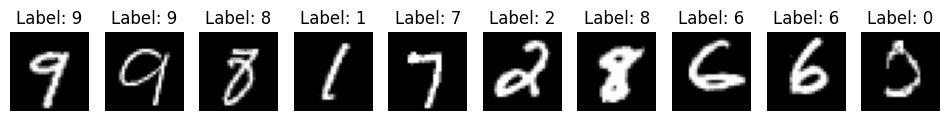

In [21]:
import matplotlib.pyplot as plt

# Visualize random samples
def visualize_random_samples(loader, num_samples=10):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()

print("Visualizing random samples from Train Dataset:")
visualize_random_samples(train_loader)


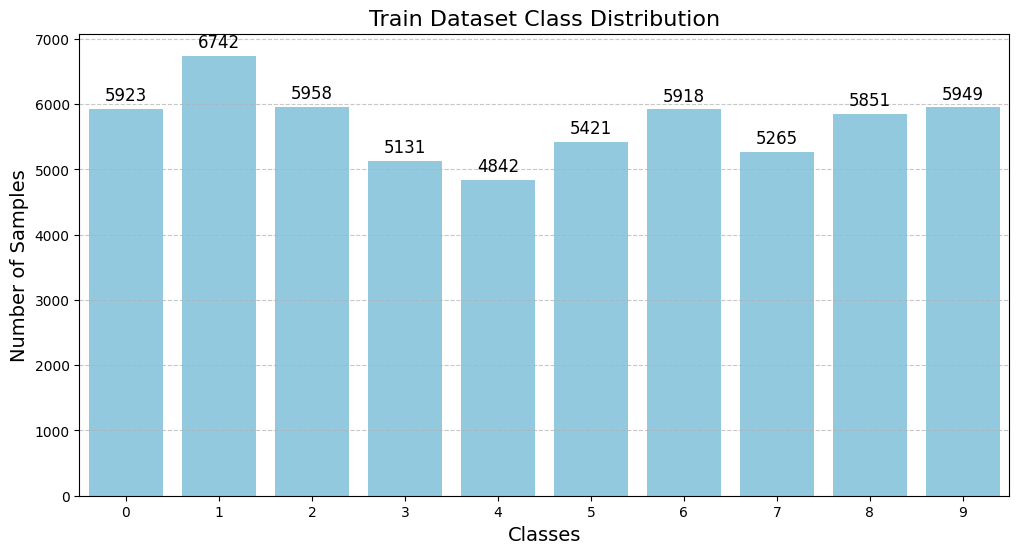

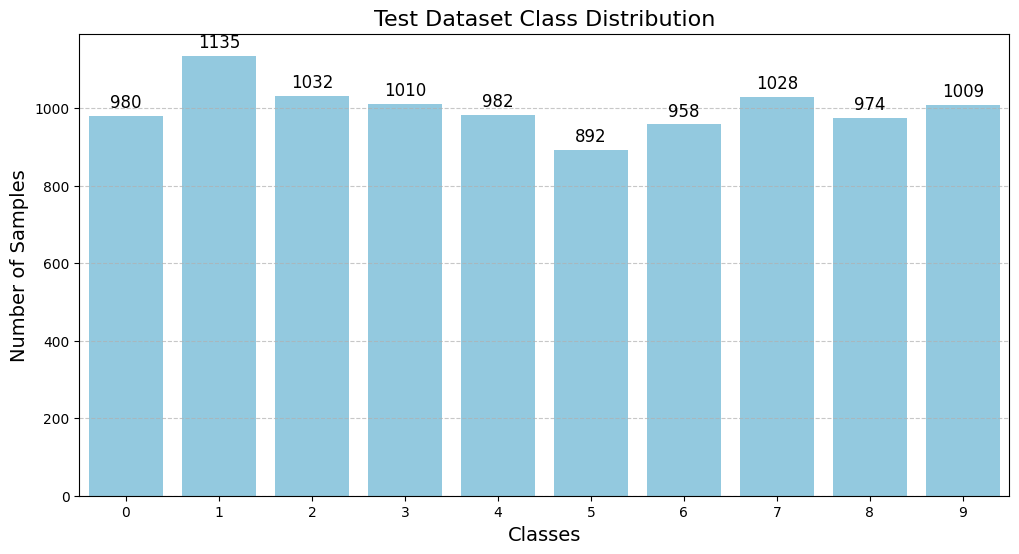

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Function to analyze and visualize class distribution with counts annotated
def analyze_and_plot_class_distribution_seaborn(loader, name):
    # Count the class occurrences
    class_counts = Counter()
    for _, labels in loader:
        class_counts.update(labels.tolist())

    # Prepare data for Seaborn
    classes = sorted(class_counts.keys())
    counts = [class_counts[cls] for cls in classes]

    # Create a Seaborn bar plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=classes, y=counts, color="skyblue")  # Use a single color
    plt.xlabel("Classes", fontsize=14)
    plt.ylabel("Number of Samples", fontsize=14)
    plt.title(f"{name} Class Distribution", fontsize=16)
    plt.xticks(classes)

    # Annotate counts on top of each bar
    for i, count in enumerate(counts):
        ax.text(i, count + max(counts) * 0.01,  # Adjust position slightly above the bar
                str(count), ha='center', va='bottom', fontsize=12)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Analyze and visualize the class distribution for train and test datasets
analyze_and_plot_class_distribution_seaborn(train_loader, "Train Dataset")
analyze_and_plot_class_distribution_seaborn(test_loader, "Test Dataset")


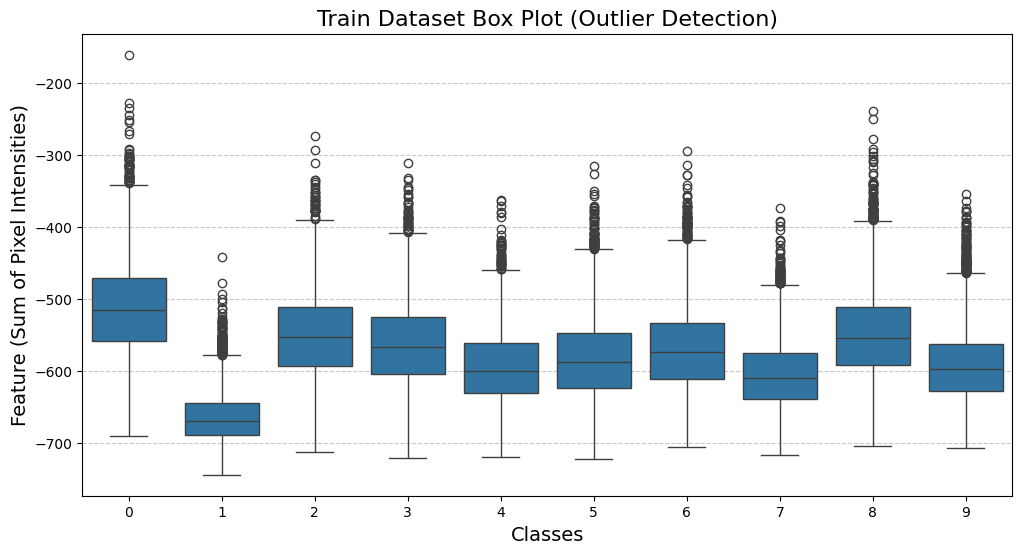

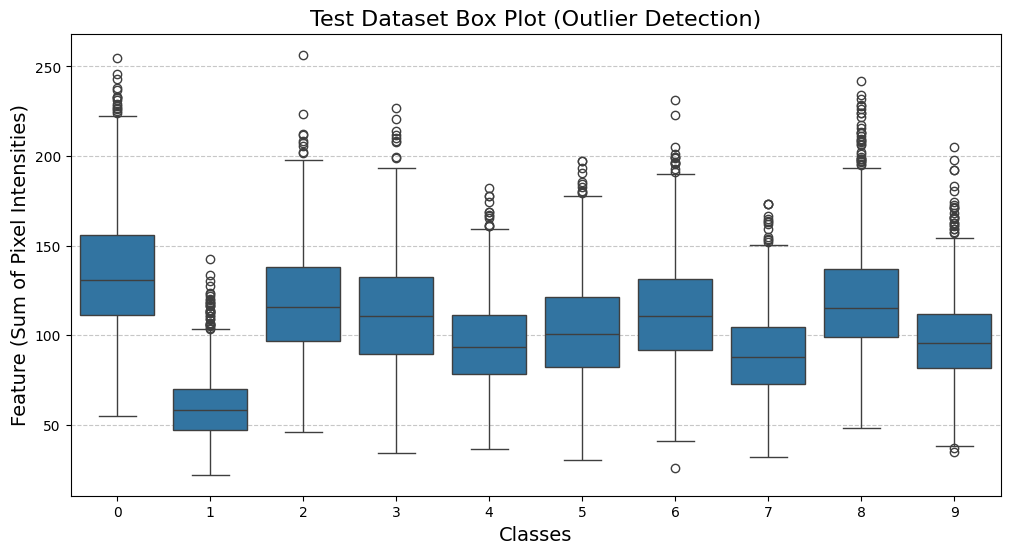

In [23]:
import pandas as pd

# Prepare data for boxplot
def prepare_data_for_boxplot(loader):
    data = []
    for images, labels in loader:
        # Compute a representative feature for boxplot (e.g., sum of pixel values)
        feature = images.view(images.size(0), -1).sum(dim=1).tolist()
        data.extend(zip(labels.tolist(), feature))
    return pd.DataFrame(data, columns=["Class", "Feature"])

# Generate box plot
def plot_boxplot(df, title):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Class", y="Feature", data=df)
    plt.xlabel("Classes", fontsize=14)
    plt.ylabel("Feature (Sum of Pixel Intensities)", fontsize=14)
    plt.title(title, fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Prepare data for train and test loaders
train_df = prepare_data_for_boxplot(train_loader)
test_df = prepare_data_for_boxplot(test_loader)

# Plot boxplots for train and test datasets
plot_boxplot(train_df, "Train Dataset Box Plot (Outlier Detection)")
plot_boxplot(test_df, "Test Dataset Box Plot (Outlier Detection)")


In [24]:
# Initialize the model
model = SimpleNN()

In [25]:
model

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [27]:
# Print the total number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal Trainable Parameters: {count_parameters(model)}")


Total Trainable Parameters: 109386


Training on cuda


Epoch [1/50]: 100%|██████████| 1782/1782 [00:09<00:00, 183.24batch/s, Loss=0.3628]


Epoch [1/50] - Train Loss: 0.3628, Train Acc: 0.8910, Test Loss: 0.6205, Test Acc: 0.8931


Epoch [2/50]: 100%|██████████| 1782/1782 [00:09<00:00, 191.07batch/s, Loss=0.1735]


Epoch [2/50] - Train Loss: 0.1735, Train Acc: 0.9466, Test Loss: 0.4600, Test Acc: 0.9041


Epoch [3/50]: 100%|██████████| 1782/1782 [00:09<00:00, 188.40batch/s, Loss=0.1310]


Epoch [3/50] - Train Loss: 0.1310, Train Acc: 0.9586, Test Loss: 0.2719, Test Acc: 0.9481


Epoch [4/50]: 100%|██████████| 1782/1782 [00:09<00:00, 192.09batch/s, Loss=0.1120]


Epoch [4/50] - Train Loss: 0.1120, Train Acc: 0.9652, Test Loss: 0.2270, Test Acc: 0.9564


Epoch [5/50]: 100%|██████████| 1782/1782 [00:08<00:00, 198.48batch/s, Loss=0.0962]


Epoch [5/50] - Train Loss: 0.0962, Train Acc: 0.9696, Test Loss: 0.2187, Test Acc: 0.9489


Epoch [6/50]: 100%|██████████| 1782/1782 [00:09<00:00, 197.74batch/s, Loss=0.0854]


Epoch [6/50] - Train Loss: 0.0854, Train Acc: 0.9726, Test Loss: 0.2221, Test Acc: 0.9413


Epoch [7/50]: 100%|██████████| 1782/1782 [00:09<00:00, 189.41batch/s, Loss=0.0784]


Epoch [7/50] - Train Loss: 0.0784, Train Acc: 0.9752, Test Loss: 0.2091, Test Acc: 0.9463


Epoch [8/50]: 100%|██████████| 1782/1782 [00:09<00:00, 188.90batch/s, Loss=0.0696]


Epoch [8/50] - Train Loss: 0.0696, Train Acc: 0.9781, Test Loss: 0.1685, Test Acc: 0.9563


Epoch [9/50]: 100%|██████████| 1782/1782 [00:08<00:00, 201.62batch/s, Loss=0.0639]


Epoch [9/50] - Train Loss: 0.0639, Train Acc: 0.9790, Test Loss: 0.1920, Test Acc: 0.9443


Epoch [10/50]: 100%|██████████| 1782/1782 [00:08<00:00, 200.06batch/s, Loss=0.0590]


Epoch [10/50] - Train Loss: 0.0590, Train Acc: 0.9808, Test Loss: 0.2071, Test Acc: 0.9342


Epoch [11/50]: 100%|██████████| 1782/1782 [00:10<00:00, 173.92batch/s, Loss=0.0587]


Epoch [11/50] - Train Loss: 0.0587, Train Acc: 0.9810, Test Loss: 0.1954, Test Acc: 0.9436


Epoch [12/50]: 100%|██████████| 1782/1782 [00:09<00:00, 183.97batch/s, Loss=0.0493]


Epoch [12/50] - Train Loss: 0.0493, Train Acc: 0.9838, Test Loss: 0.2130, Test Acc: 0.9298


Epoch [13/50]: 100%|██████████| 1782/1782 [00:09<00:00, 182.47batch/s, Loss=0.0481]


Epoch [13/50] - Train Loss: 0.0481, Train Acc: 0.9843, Test Loss: 0.1884, Test Acc: 0.9434


Epoch [14/50]: 100%|██████████| 1782/1782 [00:09<00:00, 190.37batch/s, Loss=0.0468]


Epoch [14/50] - Train Loss: 0.0468, Train Acc: 0.9847, Test Loss: 0.1984, Test Acc: 0.9336


Epoch [15/50]: 100%|██████████| 1782/1782 [00:08<00:00, 199.37batch/s, Loss=0.0443]


Epoch [15/50] - Train Loss: 0.0443, Train Acc: 0.9851, Test Loss: 0.2793, Test Acc: 0.9038


Epoch [16/50]: 100%|██████████| 1782/1782 [00:09<00:00, 188.67batch/s, Loss=0.0409]


Epoch [16/50] - Train Loss: 0.0409, Train Acc: 0.9860, Test Loss: 0.2013, Test Acc: 0.9350


Epoch [17/50]: 100%|██████████| 1782/1782 [00:09<00:00, 195.45batch/s, Loss=0.0388]


Epoch [17/50] - Train Loss: 0.0388, Train Acc: 0.9868, Test Loss: 0.1992, Test Acc: 0.9358


Epoch [18/50]: 100%|██████████| 1782/1782 [00:09<00:00, 197.96batch/s, Loss=0.0371]


Epoch [18/50] - Train Loss: 0.0371, Train Acc: 0.9880, Test Loss: 0.1491, Test Acc: 0.9515


Epoch [19/50]: 100%|██████████| 1782/1782 [00:09<00:00, 186.94batch/s, Loss=0.0372]


Epoch [19/50] - Train Loss: 0.0372, Train Acc: 0.9877, Test Loss: 0.2102, Test Acc: 0.9303


Epoch [20/50]: 100%|██████████| 1782/1782 [00:09<00:00, 184.70batch/s, Loss=0.0360]


Epoch [20/50] - Train Loss: 0.0360, Train Acc: 0.9878, Test Loss: 0.1961, Test Acc: 0.9385


Epoch [21/50]: 100%|██████████| 1782/1782 [00:10<00:00, 171.62batch/s, Loss=0.0338]


Epoch [21/50] - Train Loss: 0.0338, Train Acc: 0.9886, Test Loss: 0.2215, Test Acc: 0.9349


Epoch [22/50]: 100%|██████████| 1782/1782 [00:09<00:00, 188.80batch/s, Loss=0.0311]


Epoch [22/50] - Train Loss: 0.0311, Train Acc: 0.9894, Test Loss: 0.1724, Test Acc: 0.9449


Epoch [23/50]: 100%|██████████| 1782/1782 [00:09<00:00, 193.23batch/s, Loss=0.0325]


Epoch [23/50] - Train Loss: 0.0325, Train Acc: 0.9895, Test Loss: 0.1813, Test Acc: 0.9453


Epoch [24/50]: 100%|██████████| 1782/1782 [00:09<00:00, 190.11batch/s, Loss=0.0280]


Epoch [24/50] - Train Loss: 0.0280, Train Acc: 0.9904, Test Loss: 0.3624, Test Acc: 0.8936


Epoch [25/50]: 100%|██████████| 1782/1782 [00:11<00:00, 154.99batch/s, Loss=0.0305]


Epoch [25/50] - Train Loss: 0.0305, Train Acc: 0.9899, Test Loss: 0.2732, Test Acc: 0.9167


Epoch [26/50]: 100%|██████████| 1782/1782 [00:10<00:00, 170.38batch/s, Loss=0.0275]


Epoch [26/50] - Train Loss: 0.0275, Train Acc: 0.9909, Test Loss: 0.3115, Test Acc: 0.9108


Epoch [27/50]: 100%|██████████| 1782/1782 [00:10<00:00, 172.80batch/s, Loss=0.0281]


Epoch [27/50] - Train Loss: 0.0281, Train Acc: 0.9905, Test Loss: 0.2316, Test Acc: 0.9319


Epoch [28/50]: 100%|██████████| 1782/1782 [00:09<00:00, 178.94batch/s, Loss=0.0266]


Epoch [28/50] - Train Loss: 0.0266, Train Acc: 0.9913, Test Loss: 0.2589, Test Acc: 0.9279


Epoch [29/50]: 100%|██████████| 1782/1782 [00:09<00:00, 191.07batch/s, Loss=0.0296]


Epoch [29/50] - Train Loss: 0.0296, Train Acc: 0.9902, Test Loss: 0.2547, Test Acc: 0.9225


Epoch [30/50]: 100%|██████████| 1782/1782 [00:09<00:00, 189.00batch/s, Loss=0.0243]


Epoch [30/50] - Train Loss: 0.0243, Train Acc: 0.9920, Test Loss: 0.2285, Test Acc: 0.9356


Epoch [31/50]: 100%|██████████| 1782/1782 [00:09<00:00, 186.00batch/s, Loss=0.0260]


Epoch [31/50] - Train Loss: 0.0260, Train Acc: 0.9916, Test Loss: 0.2443, Test Acc: 0.9320


Epoch [32/50]: 100%|██████████| 1782/1782 [00:09<00:00, 183.98batch/s, Loss=0.0244]


Epoch [32/50] - Train Loss: 0.0244, Train Acc: 0.9923, Test Loss: 0.2832, Test Acc: 0.9261


Epoch [33/50]: 100%|██████████| 1782/1782 [00:09<00:00, 196.02batch/s, Loss=0.0258]


Epoch [33/50] - Train Loss: 0.0258, Train Acc: 0.9916, Test Loss: 0.2833, Test Acc: 0.9237


Epoch [34/50]: 100%|██████████| 1782/1782 [00:09<00:00, 196.93batch/s, Loss=0.0225]


Epoch [34/50] - Train Loss: 0.0225, Train Acc: 0.9929, Test Loss: 0.3536, Test Acc: 0.9051


Epoch [35/50]: 100%|██████████| 1782/1782 [00:09<00:00, 178.94batch/s, Loss=0.0226]


Epoch [35/50] - Train Loss: 0.0226, Train Acc: 0.9928, Test Loss: 0.2929, Test Acc: 0.9274


Epoch [36/50]: 100%|██████████| 1782/1782 [00:09<00:00, 183.43batch/s, Loss=0.0226]


Epoch [36/50] - Train Loss: 0.0226, Train Acc: 0.9925, Test Loss: 0.3853, Test Acc: 0.9007


Epoch [37/50]: 100%|██████████| 1782/1782 [00:09<00:00, 189.16batch/s, Loss=0.0227]


Epoch [37/50] - Train Loss: 0.0227, Train Acc: 0.9926, Test Loss: 0.3367, Test Acc: 0.9178


Epoch [38/50]: 100%|██████████| 1782/1782 [00:09<00:00, 197.80batch/s, Loss=0.0232]


Epoch [38/50] - Train Loss: 0.0232, Train Acc: 0.9928, Test Loss: 0.4309, Test Acc: 0.8991


Epoch [39/50]: 100%|██████████| 1782/1782 [00:09<00:00, 188.53batch/s, Loss=0.0211]


Epoch [39/50] - Train Loss: 0.0211, Train Acc: 0.9932, Test Loss: 0.3833, Test Acc: 0.9143


Epoch [40/50]: 100%|██████████| 1782/1782 [00:09<00:00, 189.14batch/s, Loss=0.0257]


Epoch [40/50] - Train Loss: 0.0257, Train Acc: 0.9920, Test Loss: 0.3232, Test Acc: 0.9231


Epoch [41/50]: 100%|██████████| 1782/1782 [00:09<00:00, 195.80batch/s, Loss=0.0206]


Epoch [41/50] - Train Loss: 0.0206, Train Acc: 0.9935, Test Loss: 0.3555, Test Acc: 0.9162


Epoch [42/50]: 100%|██████████| 1782/1782 [00:09<00:00, 194.47batch/s, Loss=0.0225]


Epoch [42/50] - Train Loss: 0.0225, Train Acc: 0.9928, Test Loss: 0.2594, Test Acc: 0.9380


Epoch [43/50]: 100%|██████████| 1782/1782 [00:09<00:00, 191.68batch/s, Loss=0.0181]


Epoch [43/50] - Train Loss: 0.0181, Train Acc: 0.9944, Test Loss: 0.3640, Test Acc: 0.9194


Epoch [44/50]: 100%|██████████| 1782/1782 [00:09<00:00, 193.44batch/s, Loss=0.0233]


Epoch [44/50] - Train Loss: 0.0233, Train Acc: 0.9926, Test Loss: 0.4228, Test Acc: 0.9077


Epoch [45/50]: 100%|██████████| 1782/1782 [00:09<00:00, 196.94batch/s, Loss=0.0198]


Epoch [45/50] - Train Loss: 0.0198, Train Acc: 0.9938, Test Loss: 0.3637, Test Acc: 0.9212


Epoch [46/50]: 100%|██████████| 1782/1782 [00:09<00:00, 190.26batch/s, Loss=0.0221]


Epoch [46/50] - Train Loss: 0.0221, Train Acc: 0.9934, Test Loss: 0.5209, Test Acc: 0.8885


Epoch [47/50]: 100%|██████████| 1782/1782 [00:09<00:00, 184.21batch/s, Loss=0.0157]


Epoch [47/50] - Train Loss: 0.0157, Train Acc: 0.9952, Test Loss: 0.4576, Test Acc: 0.8980


Epoch [48/50]: 100%|██████████| 1782/1782 [00:09<00:00, 186.91batch/s, Loss=0.0204]


Epoch [48/50] - Train Loss: 0.0204, Train Acc: 0.9940, Test Loss: 0.3432, Test Acc: 0.9213


Epoch [49/50]: 100%|██████████| 1782/1782 [00:08<00:00, 202.49batch/s, Loss=0.0178]


Epoch [49/50] - Train Loss: 0.0178, Train Acc: 0.9942, Test Loss: 0.3239, Test Acc: 0.9328


Epoch [50/50]: 100%|██████████| 1782/1782 [00:09<00:00, 185.91batch/s, Loss=0.0233]


Epoch [50/50] - Train Loss: 0.0233, Train Acc: 0.9929, Test Loss: 0.3859, Test Acc: 0.9178
Training complete!


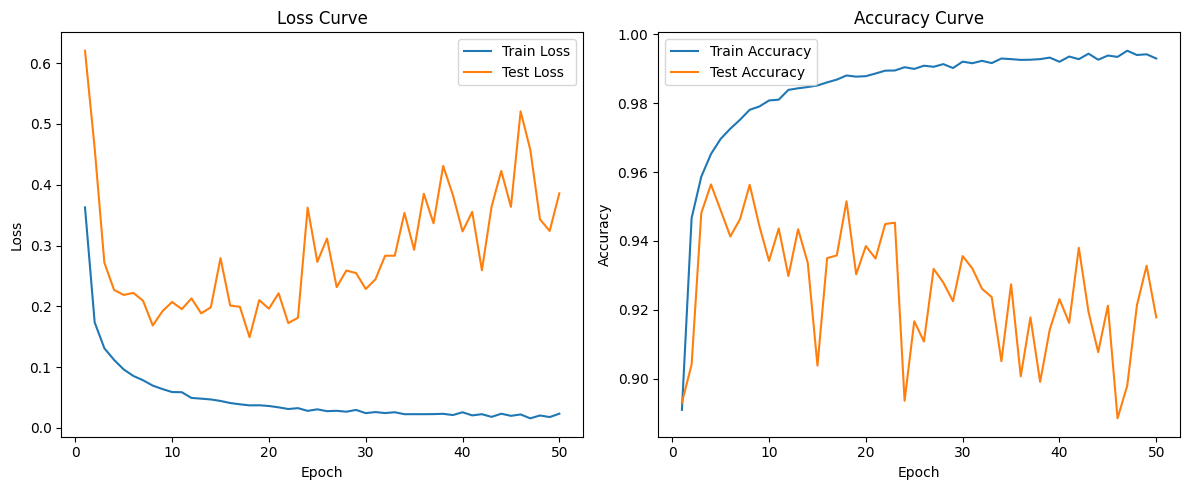

In [28]:
train_model(model, test_loader=test_loader, train_loader=train_loader, num_epochs=50)

Training on cuda
Classification report for test data:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       980
           1       0.98      0.97      0.98      1135
           2       0.95      0.95      0.95      1032
           3       0.89      0.98      0.93      1010
           4       0.98      0.74      0.85       982
           5       0.96      0.88      0.92       892
           6       0.99      0.84      0.91       958
           7       0.94      0.95      0.95      1028
           8       0.91      0.90      0.91       974
           9       0.76      0.96      0.85      1009

    accuracy                           0.92     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.92      0.92     10000



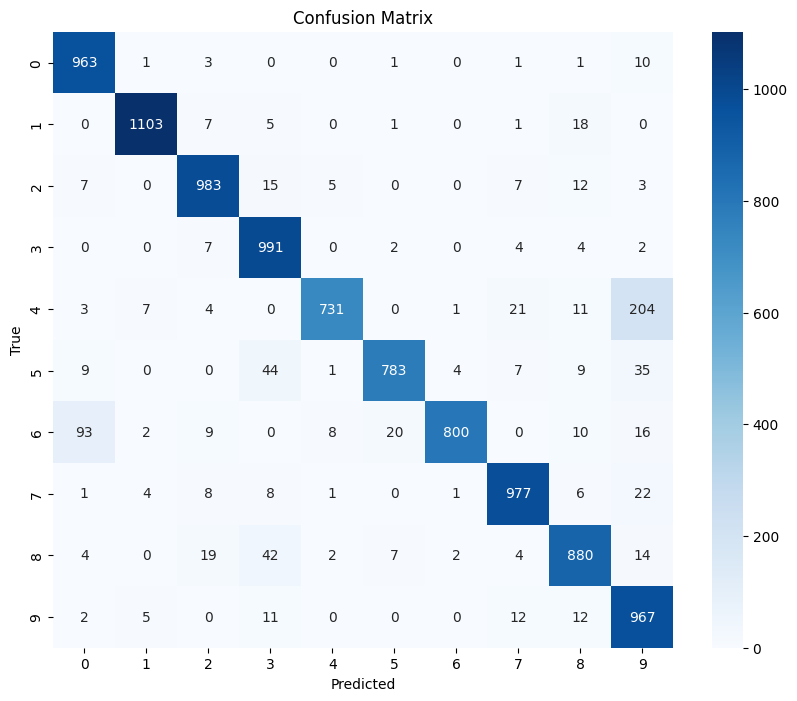

In [36]:
evaluate_model(model, test_loader)

In [37]:
# load the data from pickle
train_loader_3 = load_from_pickle("train_3.pkl")
train_loader_4 = load_from_pickle("train_4.pkl")
train_loader_7 = load_from_pickle("train_7.pkl")

In [38]:
def print_loader_info(loader, name):
    # Extract a batch of data
    images, labels = next(iter(loader))

    # Print information about the loader
    print(f"Information about {name}:")
    print(f"  - Image Shape: {images.shape}")  # e.g., (batch_size, channels, height, width)
    print(f"  - Label Shape: {labels.shape}")  # e.g., (batch_size,)
    print(f"  - Image Data Type: {images.dtype}")
    print(f"  - Label Data Type: {labels.dtype}")
    print(f"  - Number of Samples in {name}: {len(loader.dataset)}")
    print("-" * 50)

# Print information about the three loaders
print_loader_info(train_loader_3, "Train Loader 3")
print_loader_info(train_loader_4, "Train Loader 4")
print_loader_info(train_loader_7, "Train Loader 7")


Information about Train Loader 3:
  - Image Shape: torch.Size([32, 1, 28, 28])
  - Label Shape: torch.Size([32])
  - Image Data Type: torch.float32
  - Label Data Type: torch.int64
  - Number of Samples in Train Loader 3: 1000
--------------------------------------------------
Information about Train Loader 4:
  - Image Shape: torch.Size([32, 1, 28, 28])
  - Label Shape: torch.Size([32])
  - Image Data Type: torch.float32
  - Label Data Type: torch.int64
  - Number of Samples in Train Loader 4: 1000
--------------------------------------------------
Information about Train Loader 7:
  - Image Shape: torch.Size([32, 1, 28, 28])
  - Label Shape: torch.Size([32])
  - Image Data Type: torch.float32
  - Label Data Type: torch.int64
  - Number of Samples in Train Loader 7: 1000
--------------------------------------------------


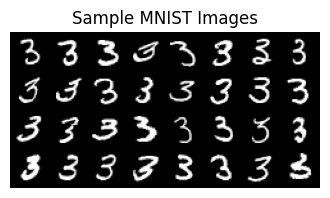

In [39]:
plot_mnist_data(train_loader_3)

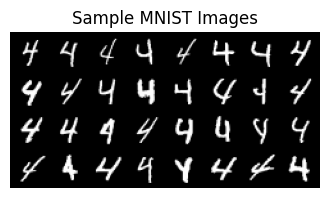

In [40]:
plot_mnist_data(train_loader_4)

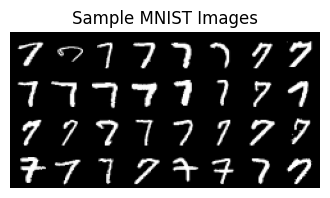

In [41]:
plot_mnist_data(train_loader_7)

Training on cuda


Epoch [1/10]: 100%|██████████| 32/32 [00:00<00:00, 242.45batch/s, Loss=0.1379]


Epoch [1/10] - Train Loss: 0.1379, Train Acc: 0.9850, Test Loss: 0.6493, Test Acc: 0.8599


Epoch [2/10]: 100%|██████████| 32/32 [00:00<00:00, 237.44batch/s, Loss=0.0015]


Epoch [2/10] - Train Loss: 0.0015, Train Acc: 0.9990, Test Loss: 0.7578, Test Acc: 0.8388


Epoch [3/10]: 100%|██████████| 32/32 [00:00<00:00, 208.42batch/s, Loss=0.0000]


Epoch [3/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.7743, Test Acc: 0.8364


Epoch [4/10]: 100%|██████████| 32/32 [00:00<00:00, 180.52batch/s, Loss=0.0000]


Epoch [4/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.7727, Test Acc: 0.8362


Epoch [5/10]: 100%|██████████| 32/32 [00:00<00:00, 229.84batch/s, Loss=0.0000]


Epoch [5/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.7763, Test Acc: 0.8362


Epoch [6/10]: 100%|██████████| 32/32 [00:00<00:00, 234.62batch/s, Loss=0.0000]


Epoch [6/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.7735, Test Acc: 0.8361


Epoch [7/10]: 100%|██████████| 32/32 [00:00<00:00, 237.69batch/s, Loss=0.0000]


Epoch [7/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.7744, Test Acc: 0.8361


Epoch [8/10]: 100%|██████████| 32/32 [00:00<00:00, 235.22batch/s, Loss=0.0000]


Epoch [8/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.7733, Test Acc: 0.8361


Epoch [9/10]: 100%|██████████| 32/32 [00:00<00:00, 238.86batch/s, Loss=0.0000]


Epoch [9/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.7742, Test Acc: 0.8361


Epoch [10/10]: 100%|██████████| 32/32 [00:00<00:00, 229.15batch/s, Loss=0.0000]


Epoch [10/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.7738, Test Acc: 0.8360
Fine-tuning complete!


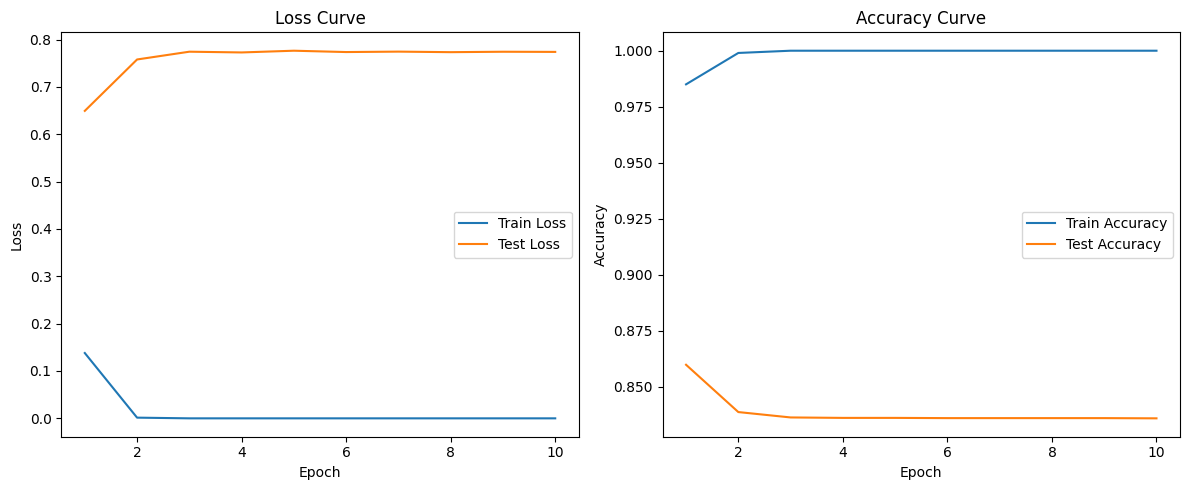

In [42]:
train_model(model, train_loader_3, test_loader=test_loader,num_epochs=10, fine_tuning=True)

Training on cuda
Classification report for test data:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       980
           1       0.98      0.97      0.98      1135
           2       0.96      0.83      0.89      1032
           3       0.50      1.00      0.67      1010
           4       0.98      0.72      0.83       982
           5       0.96      0.71      0.82       892
           6       0.99      0.81      0.89       958
           7       0.96      0.82      0.88      1028
           8       0.91      0.61      0.73       974
           9       0.73      0.88      0.80      1009

    accuracy                           0.84     10000
   macro avg       0.89      0.83      0.84     10000
weighted avg       0.89      0.84      0.84     10000



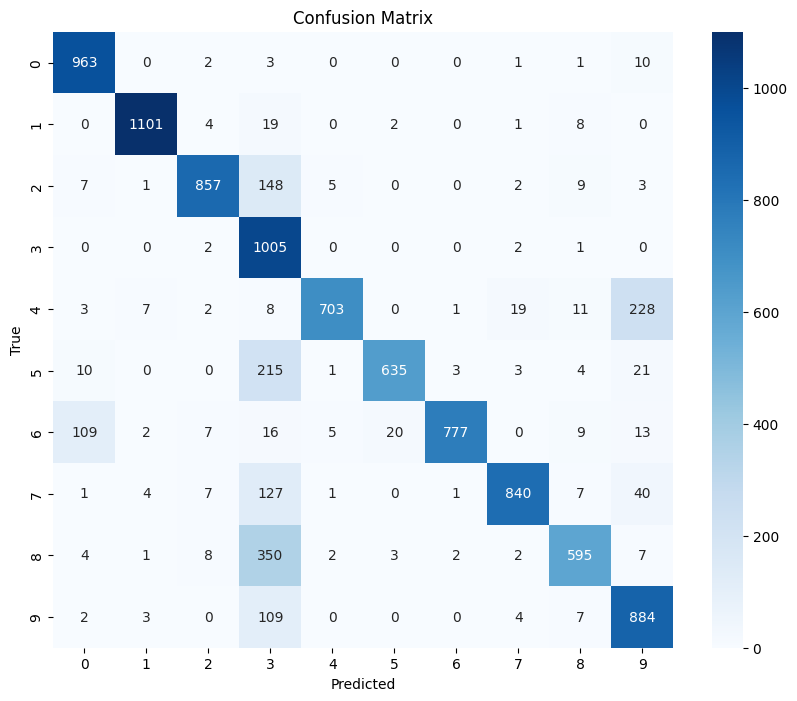

In [43]:
evaluate_model(model, test_loader)

Training on cuda


Epoch [1/10]: 100%|██████████| 32/32 [00:00<00:00, 233.43batch/s, Loss=0.1335]


Epoch [1/10] - Train Loss: 0.1335, Train Acc: 0.9800, Test Loss: 0.6370, Test Acc: 0.8652


Epoch [2/10]: 100%|██████████| 32/32 [00:00<00:00, 213.33batch/s, Loss=0.0006]


Epoch [2/10] - Train Loss: 0.0006, Train Acc: 1.0000, Test Loss: 0.6331, Test Acc: 0.8667


Epoch [3/10]: 100%|██████████| 32/32 [00:00<00:00, 181.55batch/s, Loss=0.0000]


Epoch [3/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.6345, Test Acc: 0.8665


Epoch [4/10]: 100%|██████████| 32/32 [00:00<00:00, 227.08batch/s, Loss=0.0000]


Epoch [4/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.6336, Test Acc: 0.8662


Epoch [5/10]: 100%|██████████| 32/32 [00:00<00:00, 237.86batch/s, Loss=0.0000]


Epoch [5/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.6342, Test Acc: 0.8662


Epoch [6/10]: 100%|██████████| 32/32 [00:00<00:00, 229.79batch/s, Loss=0.0000]


Epoch [6/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.6341, Test Acc: 0.8662


Epoch [7/10]: 100%|██████████| 32/32 [00:00<00:00, 230.88batch/s, Loss=0.0000]


Epoch [7/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.6344, Test Acc: 0.8661


Epoch [8/10]: 100%|██████████| 32/32 [00:00<00:00, 221.61batch/s, Loss=0.0000]


Epoch [8/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.6346, Test Acc: 0.8661


Epoch [9/10]: 100%|██████████| 32/32 [00:00<00:00, 235.79batch/s, Loss=0.0000]


Epoch [9/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.6354, Test Acc: 0.8661


Epoch [10/10]: 100%|██████████| 32/32 [00:00<00:00, 228.73batch/s, Loss=0.0000]


Epoch [10/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.6355, Test Acc: 0.8662
Fine-tuning complete!


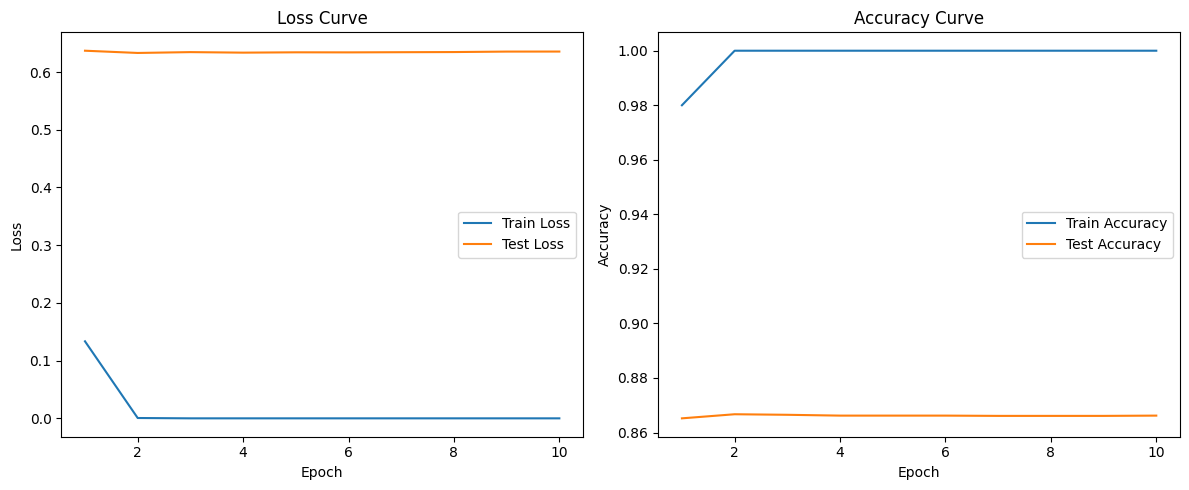

In [44]:
train_model(model, train_loader_4, test_loader=test_loader, num_epochs=10, fine_tuning=True )

Training on cuda
Classification report for test data:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       980
           1       0.99      0.97      0.98      1135
           2       0.97      0.83      0.89      1032
           3       0.54      0.99      0.70      1010
           4       0.91      0.93      0.92       982
           5       0.95      0.74      0.83       892
           6       0.99      0.77      0.86       958
           7       0.97      0.88      0.92      1028
           8       0.92      0.62      0.74       974
           9       0.88      0.92      0.90      1009

    accuracy                           0.87     10000
   macro avg       0.90      0.86      0.87     10000
weighted avg       0.90      0.87      0.87     10000



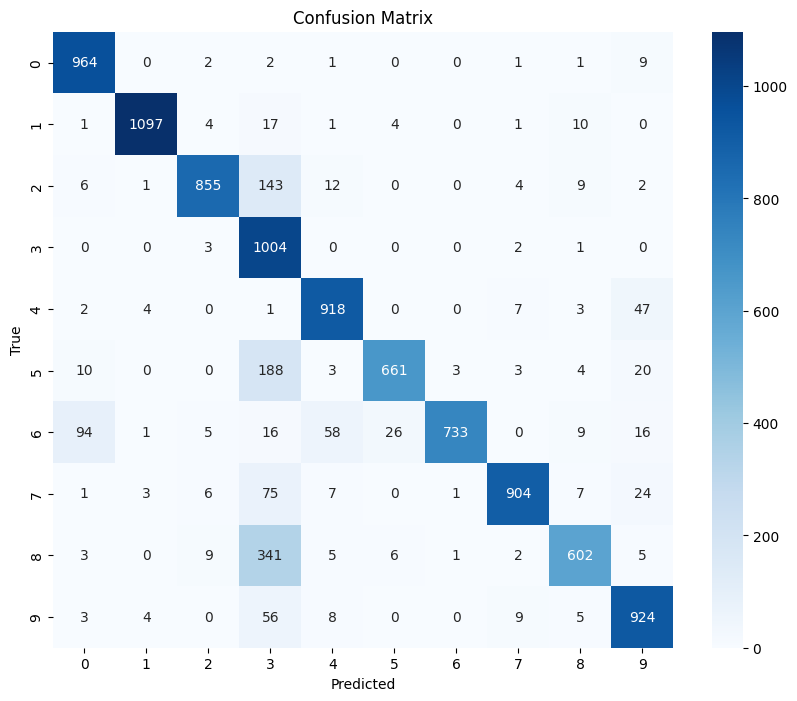

In [45]:
evaluate_model(model, test_loader)

Training on cuda


Epoch [1/10]: 100%|██████████| 32/32 [00:00<00:00, 215.43batch/s, Loss=0.2110]


Epoch [1/10] - Train Loss: 0.2110, Train Acc: 0.9700, Test Loss: 0.5651, Test Acc: 0.8815


Epoch [2/10]: 100%|██████████| 32/32 [00:00<00:00, 219.51batch/s, Loss=0.0026]


Epoch [2/10] - Train Loss: 0.0026, Train Acc: 0.9990, Test Loss: 0.5858, Test Acc: 0.8794


Epoch [3/10]: 100%|██████████| 32/32 [00:00<00:00, 234.17batch/s, Loss=0.0000]


Epoch [3/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.6015, Test Acc: 0.8767


Epoch [4/10]: 100%|██████████| 32/32 [00:00<00:00, 228.49batch/s, Loss=0.0000]


Epoch [4/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.6018, Test Acc: 0.8767


Epoch [5/10]: 100%|██████████| 32/32 [00:00<00:00, 224.68batch/s, Loss=0.0000]


Epoch [5/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.6018, Test Acc: 0.8765


Epoch [6/10]: 100%|██████████| 32/32 [00:00<00:00, 236.62batch/s, Loss=0.0000]


Epoch [6/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.6042, Test Acc: 0.8763


Epoch [7/10]: 100%|██████████| 32/32 [00:00<00:00, 240.91batch/s, Loss=0.0000]


Epoch [7/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.6051, Test Acc: 0.8758


Epoch [8/10]: 100%|██████████| 32/32 [00:00<00:00, 223.70batch/s, Loss=0.0000]


Epoch [8/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.6073, Test Acc: 0.8756


Epoch [9/10]: 100%|██████████| 32/32 [00:00<00:00, 234.57batch/s, Loss=0.0000]


Epoch [9/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.6104, Test Acc: 0.8752


Epoch [10/10]: 100%|██████████| 32/32 [00:00<00:00, 178.67batch/s, Loss=0.0000]


Epoch [10/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.6094, Test Acc: 0.8753
Fine-tuning complete!


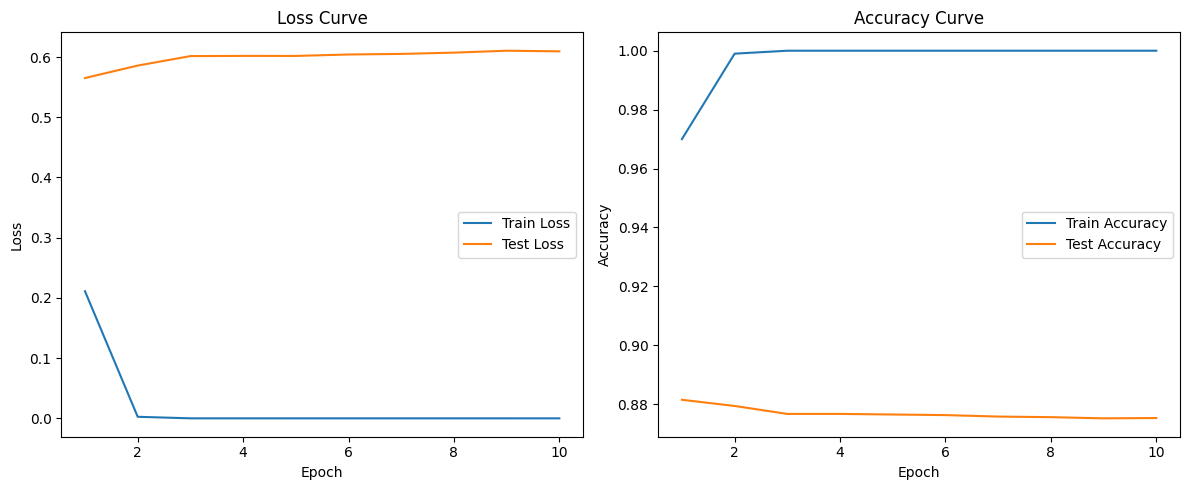

In [46]:
train_model(model, train_loader_7, test_loader=test_loader,num_epochs=10, fine_tuning=True)

Training on cuda
Classification report for test data:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       980
           1       0.99      0.97      0.98      1135
           2       0.97      0.85      0.91      1032
           3       0.67      0.99      0.80      1010
           4       0.94      0.86      0.90       982
           5       0.95      0.73      0.82       892
           6       0.99      0.77      0.87       958
           7       0.75      0.99      0.86      1028
           8       0.94      0.72      0.82       974
           9       0.88      0.86      0.87      1009

    accuracy                           0.88     10000
   macro avg       0.90      0.87      0.87     10000
weighted avg       0.90      0.88      0.88     10000



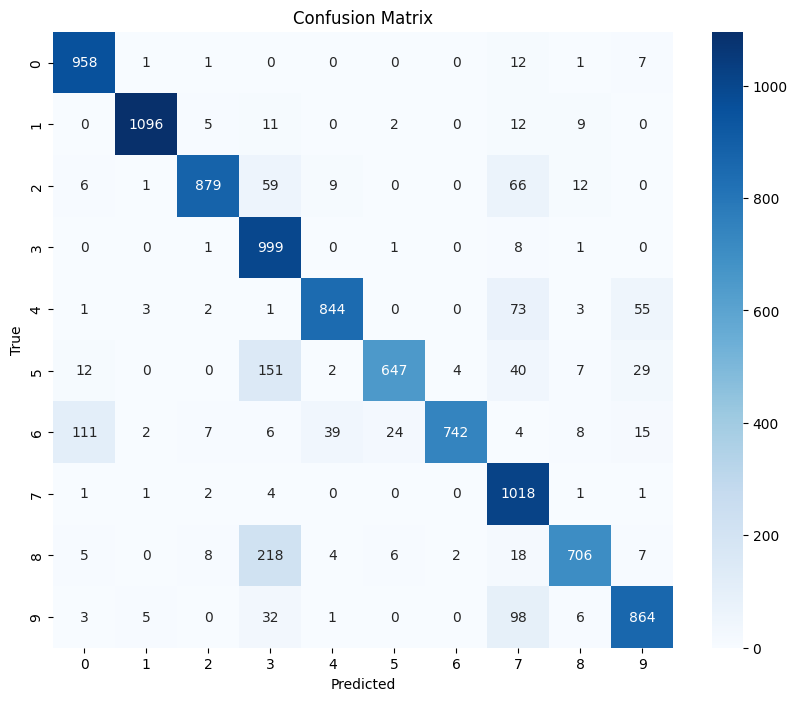

In [47]:
evaluate_model(model, test_loader)

In [48]:
# Load datasets
train_loader_3 = load_from_pickle("train_3.pkl")
train_loader_4 = load_from_pickle("train_4.pkl")
train_loader_7 = load_from_pickle("train_7.pkl")

# Extract datasets from the DataLoaders
dataset_3 = train_loader_3.dataset
dataset_4 = train_loader_4.dataset
dataset_7 = train_loader_7.dataset

# Merge the datasets
merged_dataset = ConcatDataset([dataset_3, dataset_4, dataset_7])

# Create a new DataLoader for the merged dataset
merged_train_loader = DataLoader(merged_dataset, batch_size=64, shuffle=True)

# Now, `merged_train_loader` is your combined DataLoader


Training on cuda


Epoch [1/10]: 100%|██████████| 47/47 [00:00<00:00, 138.59batch/s, Loss=0.0775]


Epoch [1/10] - Train Loss: 0.0775, Train Acc: 0.9853, Test Loss: 0.9216, Test Acc: 0.8228


Epoch [2/10]: 100%|██████████| 47/47 [00:00<00:00, 212.56batch/s, Loss=0.0245]


Epoch [2/10] - Train Loss: 0.0245, Train Acc: 0.9950, Test Loss: 1.1394, Test Acc: 0.7913


Epoch [3/10]: 100%|██████████| 47/47 [00:00<00:00, 185.47batch/s, Loss=0.0094]


Epoch [3/10] - Train Loss: 0.0094, Train Acc: 0.9960, Test Loss: 1.6919, Test Acc: 0.7385


Epoch [4/10]: 100%|██████████| 47/47 [00:00<00:00, 218.38batch/s, Loss=0.0054]


Epoch [4/10] - Train Loss: 0.0054, Train Acc: 0.9980, Test Loss: 1.9336, Test Acc: 0.7158


Epoch [5/10]: 100%|██████████| 47/47 [00:00<00:00, 225.61batch/s, Loss=0.0016]


Epoch [5/10] - Train Loss: 0.0016, Train Acc: 0.9993, Test Loss: 1.9760, Test Acc: 0.7108


Epoch [6/10]: 100%|██████████| 47/47 [00:00<00:00, 233.18batch/s, Loss=0.0008]


Epoch [6/10] - Train Loss: 0.0008, Train Acc: 0.9997, Test Loss: 2.0030, Test Acc: 0.7086


Epoch [7/10]: 100%|██████████| 47/47 [00:00<00:00, 229.74batch/s, Loss=0.0005]


Epoch [7/10] - Train Loss: 0.0005, Train Acc: 1.0000, Test Loss: 2.0637, Test Acc: 0.7037


Epoch [8/10]: 100%|██████████| 47/47 [00:00<00:00, 227.72batch/s, Loss=0.0001]


Epoch [8/10] - Train Loss: 0.0001, Train Acc: 1.0000, Test Loss: 2.0779, Test Acc: 0.7026


Epoch [9/10]: 100%|██████████| 47/47 [00:00<00:00, 235.38batch/s, Loss=0.0001]


Epoch [9/10] - Train Loss: 0.0001, Train Acc: 1.0000, Test Loss: 2.0900, Test Acc: 0.7016


Epoch [10/10]: 100%|██████████| 47/47 [00:00<00:00, 222.75batch/s, Loss=0.0001]


Epoch [10/10] - Train Loss: 0.0001, Train Acc: 1.0000, Test Loss: 2.1070, Test Acc: 0.7003
Fine-tuning complete!


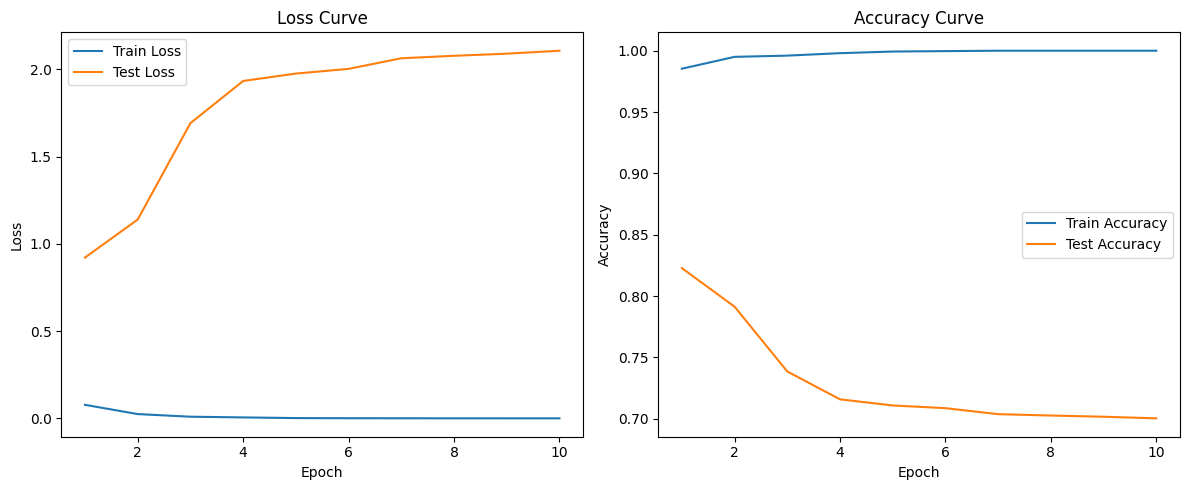

In [49]:
train_model(model, merged_train_loader, test_loader=test_loader, num_epochs=10, fine_tuning=True)

Training on cuda
Classification report for test data:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       980
           1       1.00      0.92      0.96      1135
           2       0.97      0.55      0.70      1032
           3       0.31      1.00      0.48      1010
           4       0.82      0.94      0.88       982
           5       0.90      0.20      0.32       892
           6       0.99      0.60      0.75       958
           7       0.72      0.96      0.82      1028
           8       0.95      0.14      0.24       974
           9       0.92      0.64      0.75      1009

    accuracy                           0.70     10000
   macro avg       0.85      0.69      0.68     10000
weighted avg       0.85      0.70      0.69     10000



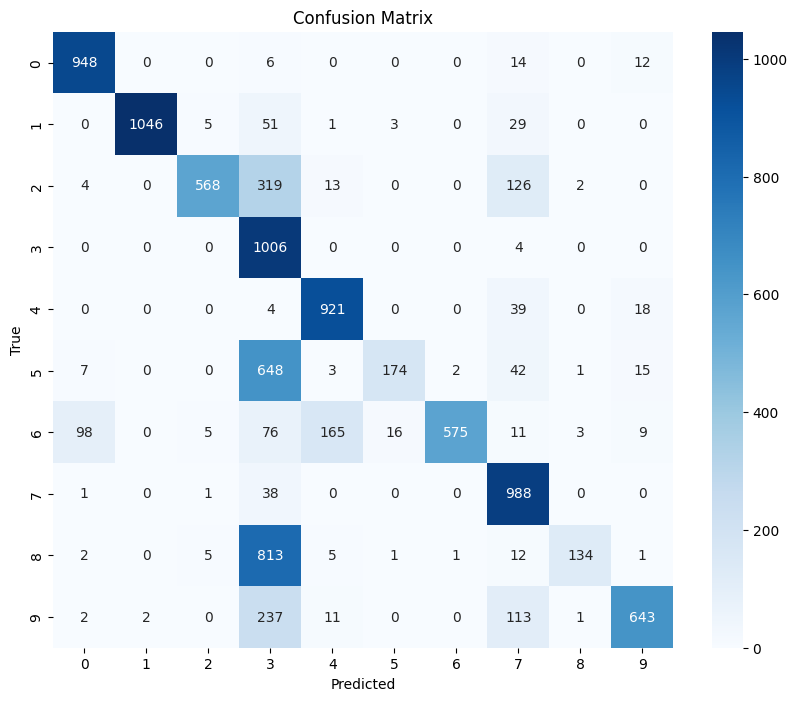

In [50]:
evaluate_model(model, test_loader)

In [51]:
# Save the model
torch.save(model.state_dict(), pretrained_model_path)
print("Model saved successfully!")

Model saved successfully!
